In [1]:
"""
Try processing without taking a fit to each sensor...First rotate E1 and E2 to x and y voltage
"""


from scipy.io import loadmat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################

fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/Demod_vs_NoDemod_spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
resid_store = np.array([])


float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
#float_list = ['6667i']



#Load CDIP Data
cdip_fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(cdip_fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]

float_list = ['6667i']
for float_id in float_list:
    
    #Ignore non profile files in this directory
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    efr_files = [efr_files[1]]
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        Pef = Pef_moving
        
        hx = HX-np.nanmean(HX)
        hy = HY-np.nanmean(HY)
        
        hx = (hx / np.std(hx)) / np.sqrt(2)
        hy = (hy / np.std(hy)) / np.sqrt(2)



        #hx_fix, hy_fix = correct_magnetometer(hx, hy)
        
        
        #angs=np.arctan2(hy_fix,hx_fix);
        angs = np.arctan2(hy, hx)
        
        e1 = E1#*sfv1
        e2 = E2#*sfv2
        
        
        ### Get the normal spectra
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,hx_fix,hy_fix);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r
        E_y = E2_r
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef_moving>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        
      
                
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
            if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                #print("All NaNs!!")
                if nancounter==0:
                    #plt.loglog(fwindow, np.transpose(VVwindow))
                    #plt.plot(np.transpose(u_y))
                    #plt.loglog(fwindow[1:], np.transpose(Eh))
                    print(make_vel_spectrum(u_y, fs))
                    
                temp1 = np.expand_dims(np.array(E_x), axis=0)
                temp2 = np.expand_dims(np.array(E_y), axis=0)
                temp3 = np.append(temp1, temp2, axis=0)
                nanstorer.append(temp3)
                #if nancounter<10:
                #    plt.figure()
                #    plt.plot(E_x)
                #    plt.plot(E_y)
                nancounter+=1
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            u_noise = 0 #This is just for testing...
            [lbound, ubound, fake] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            
            
        spec_demod = Eh
        spec_demod_corr = Eh_Eric4

        vel_name = fname_base+float_id+"/vel/"
        
        vel_fname = vel_name + file
        cut = vel_fname.find("efr")
        velfname = vel_fname[:cut]+"vel.mat"
        VEL = loadmat(velfname)
        #First get traditional spectra, then get the no-demodulation spectra...
        
        
        
        #Do the no-demodulation processing
        x = list(range(len(e1)))
        p1 = np.polyfit(x, e1, 10)
        pfit1 = np.poly1d(p1)
        fit_line1 = pfit1(x);

        p2 = np.polyfit(x, e2, 10)
        pfit2 = np.poly1d(p2)
        fit_line2 = pfit2(x);
        
        
        diff1 = (e1-fit_line1)*sfv1
        diff2 = (e2-fit_line2)*sfv2
        
        wem = (Pef_moving[-1]-Pef_moving[0])/(mlt_efr[-1]-mlt_efr[0])


        
        u_x=(diff1*np.sin(angs+alpha1)-diff2*np.cos(angs+alpha1));
        #Not sure if I have the sign right on the wem term
        u_y=(-diff1*np.cos(angs+alpha1)-diff2*np.sin(angs+alpha1)+(By/1000)*(1+c2)*wem);

        
#         E2_r =(diff1*np.sin(angs)+diff2*np.cos(angs));
#         #Not sure if I have the sign right on the wem term
#         E1_r=(diff1*np.cos(angs)-diff2*np.sin(angs))#+sfv1*(By/1000)*(1+c2)*wem);
        
#         E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
#         E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
#         u_x = E_x
#         u_y = E_y+sfv1*(By/1000)*(1+c2)*wem
        #u_x=(diff1*np.sin(angs)*np.cos(alpha1)-diff2*np.cos(angs+alpha1));
        #Not sure if I have the sign right on the wem term
        #u_y=(diff1*np.cos(angs+alpha1)-diff2*np.sin(angs+alpha1)+(By/1000)*(1+c2)*wem);
#         E2_r=diff2*np.cos(angs)+diff1*np.sin(angs);
#         #Not sure if I have the sign right on the wem term
#         E1_r=-diff2*np.sin(angs)+diff1*np.cos(angs)+(By/1000)*(1+c2)*wem;

#         E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
#         E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)

#         u_x = E_x
#         u_y = E_y
        
#         u_x = -diff2*np.sin(angs)*np.cos(alpha1)+diff1*np.cos(angs)*np.cos(alpha1) - diff2*np.cos(angs)*np.sin(alpha1)-diff1*np.sin(angs)*np.sin(alpha1)
#         u_y = -diff2*np.sin(angs)*np.sin(alpha1)+diff1*np.cos(angs)*np.sin(alpha1) + diff2*np.cos(angs)*np.cos(alpha1)+diff1*np.sin(angs)*np.cos(alpha1)+sfv1*(By/1000)*(1+c2)*wem;



        nblock = 120
        overlap = 60
        fs = 1

        #apply high pass filter
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        u_x_filt = signal.sosfilt(sos, u_x)
        u_y_filt = signal.sosfilt(sos, u_y)


        [u_x_new, t_new] = reshape_u(u_x_filt, mlt_efr, nblock, overlap, fs)

        [u_y_new, z_y] = reshape_u(u_y_filt, Pef, nblock, overlap, fs)

        UUwindow, fwindow = make_vel_spectrum(u_x_new, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y_new, fs)
        
        rot_f = 1/np.nanmean(VEL['RotP'][0])
        

        UU = UUwindow/(int(nblock/2)*fs)
        Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
        VV = VVwindow/(int(nblock/2)*fs)
        Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

        Eh = Exx+Eyy

        prof_speed = np.abs(z_y[:, 0]-z_y[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

        [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_y, prof_speed, nblock, 10, fs)

        spec_no_demod = Eh
        spec_no_demod_corr = Eh_Eric4
        
        plt.figure()
        plt.loglog(fwindow[1:], np.nanmean(spec_no_demod, axis=0), label='No Demod Raw')
        #plt.plot(fwindow[1:], np.transpose(spec_no_demod), color='k', alpha=0.2)
        plt.loglog(fwindow[1:], np.nanmean(spec_no_demod_corr, axis=0), label='No Demod Corrected')
        #plt.plot(fwindow[1:], np.transpose(spec_no_demod_corr), color='k', alpha=0.2)

        plt.loglog(fwindow[1:], np.nanmean(spec_demod, axis=0), label='Demod Raw')
        plt.loglog(fwindow[1:], np.nanmean(spec_demod_corr, axis=0), label='Demod Corrected')

        plt.axvline(x = rot_f, color = 'k', label = 'Rotatation Frequency')

        ##Get Errors
        #first need to match up teh 

        ind2 = np.where(np.abs(np.nanmean(mlt_efr)-times)==np.min(np.abs(np.nanmean(mlt_efr)-times)))
            #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
        cdip_ind = ind2[0]
        plt.plot(wave_freq, energy_density[ind2[0][0], :], label="CDIP buoy")
        plt.legend()


        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Displacement Energy Density (m^2/Hz)")
        plt.title("Spectra "+str(file.split("-")[1]) +", prof #" + str(prof_num))
        plt.show()
        #plt.savefig(save_dir + str(file.split("-")[1])+"_"+str(prof_num)+".png")
        #plt.close()



NameError: name 'hx_fix' is not defined

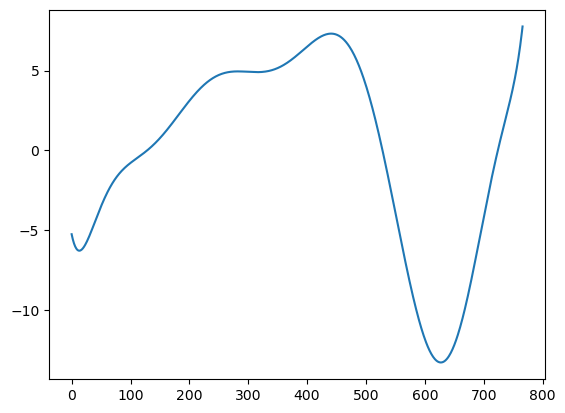

In [41]:
plt.plot(fit_line1-np.mean(fit_line1))
#plt.plot(e1)

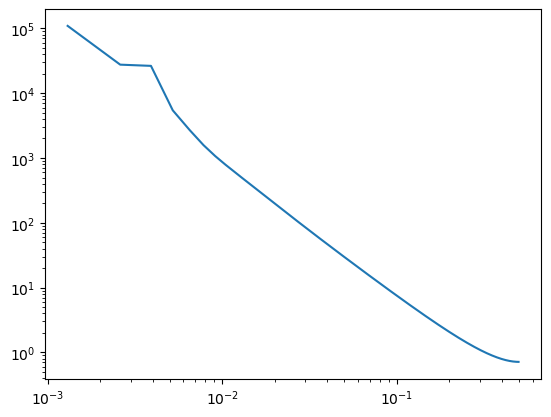

In [47]:
fs=1
w= len(fit_line1)
Uwindow = np.fft.fft(fit_line1-np.mean(fit_line1))
#print(Uwindow)
fwindow = np.fft.fftfreq(fit_line1.shape[-1], d=1/fs)
fwindow=fwindow[:int(w/2)]

Uwindow = np.delete(Uwindow,  np.s_[int(w/2):], -1)


#Take power spectra
UUwindow = np.real(Uwindow * np.conj(Uwindow))
UU = UUwindow/(int(nblock/2)*fs)
#Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
plt.loglog(fwindow[1:], UU[1:])

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/4069840138.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/4069840138.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


Text(0, 0.5, 'channel 2 (uV)')

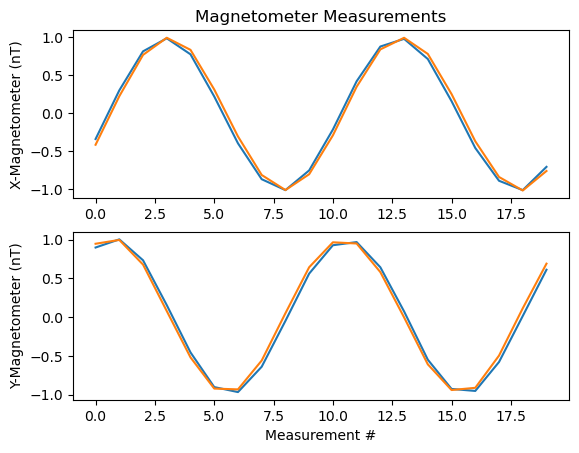

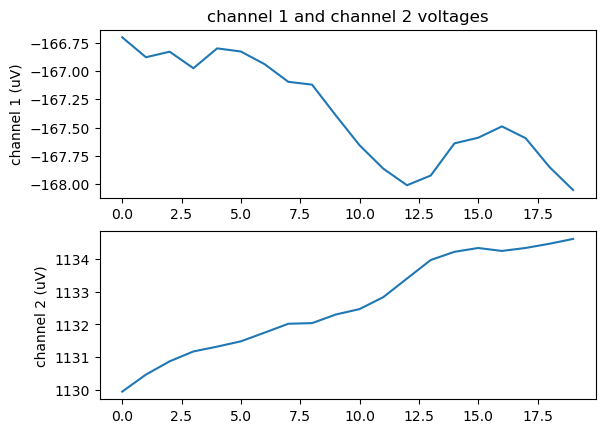

In [166]:
#plt.subplots(211)
plt.subplot(211)
plt.plot(hx[600:700])
plt.ylabel('X-Magnetometer (nT)')
plt.title("Magnetometer Measurements")
plt.subplot(212)
plt.plot(hy[600:700])

plt.ylabel("Y-Magnetometer (nT)")
plt.xlabel("Measurement #")
#fig.tight_layout()

plt.subplot(211)
plt.plot(hx_fix[600:700])
plt.ylabel('X-Magnetometer (nT)')
plt.title("Magnetometer Measurements")
plt.subplot(212)
plt.plot(hy_fix[600:700])

plt.ylabel("Y-Magnetometer (nT)")
plt.xlabel("Measurement #")
#fig.tight_layout()




plt.figure()
plt.subplot(211)
plt.plot(e1[600:700])
plt.ylabel('channel 1 (uV)')
plt.title("channel 1 and channel 2 voltages")
plt.subplot(212)
plt.plot(e2[600:700])

plt.ylabel('channel 2 (uV)')
        
    
    
#plt.figure()
#plt.subplot(211)
#plt.plot(e_x[600:700])
#plt.ylabel('x-axis voltage (uV)')
#plt.title("Channel 1 & 2 voltages transformed into x-y coordinates")
#plt.subplot(212)
#plt.plot(e_y[600:700])

#plt.ylabel('y-axis voltage (uV)')


        

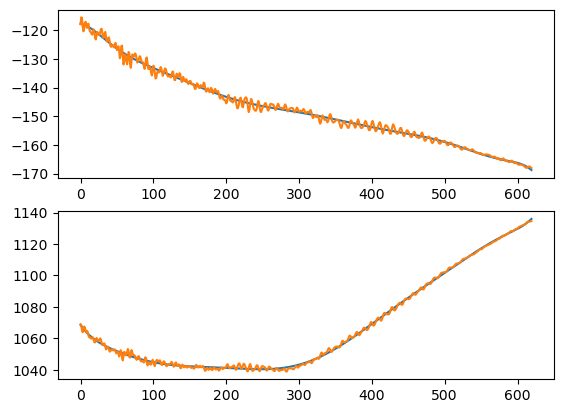

In [167]:
x = list(range(len(e1)))
p1 = np.polyfit(x, e1, 10)
pfit1 = np.poly1d(p1)
fit_line1 = pfit1(x);

p2 = np.polyfit(x, e2, 10)
pfit2 = np.poly1d(p2)
fit_line2 = pfit2(x);

plt.subplot(211)
plt.plot(fit_line1)
plt.plot(e1)
plt.subplot(212)
plt.plot(fit_line2)
plt.plot(e2)

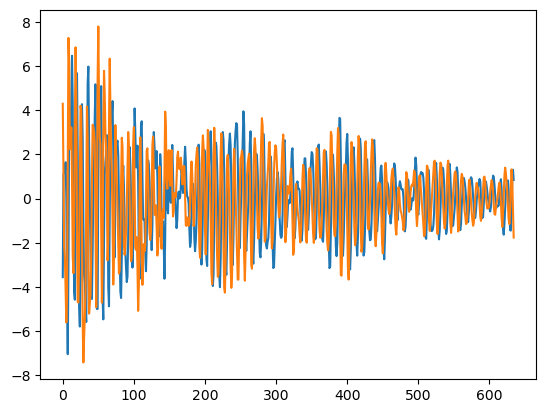

In [4]:
diff1 = (e1-fit_line1)#*sfv1
diff2 = (e2-fit_line2)#*sfv2
plt.plot(diff1)
plt.plot(diff2)

In [5]:
wem = (Pef_moving[-1]-Pef_moving[0])/(mlt_efr[-1]-mlt_efr[0])
#This is just an avg 

In [6]:
u_x=sfv1*(diff1*np.sin(angs+alpha1)-diff2*np.cos(angs+alpha1));
#Not sure if I have the sign right on the wem term
u_y=sfv1*(-diff1*np.cos(angs+alpha1)-diff2*np.sin(angs+alpha1)+(By/1000)*(1+c2)*wem);



Text(0, 0.5, 'y-axis velocity (m/s)')

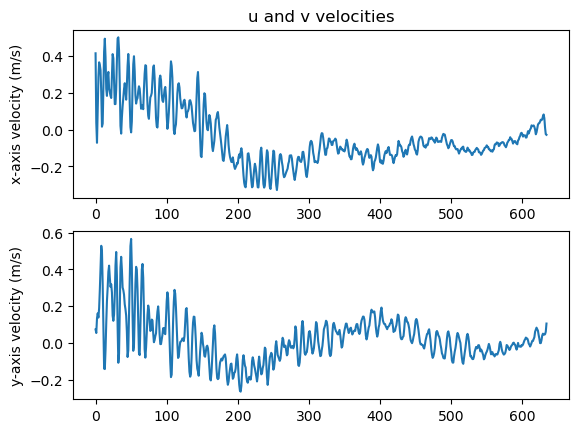

In [7]:
plt.figure()
plt.subplot(211)
plt.plot(u_x)
plt.ylabel('x-axis velocity (m/s)')
plt.title("u and v velocities")
plt.subplot(212)
plt.plot(u_y)

plt.ylabel('y-axis velocity (m/s)')



In [8]:
nblock = 120
overlap = 60
fs = 1

#apply high pass filter
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
u_x_filt = signal.sosfilt(sos, u_x)
u_y_filt = signal.sosfilt(sos, u_y)
        

[u_x_new, t_new] = reshape_u(u_x_filt, mlt_efr, nblock, overlap, fs)

[u_y_new, z_y] = reshape_u(u_y_filt, Pef, nblock, overlap, fs)

UUwindow, fwindow = make_vel_spectrum(u_x_new, fs)

VVwindow, fwindow = make_vel_spectrum(u_y_new, fs)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/337224109.py:23: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(spec_no_demod_corr, axis=0), label='No Demod Corrected')
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/337224109.py:27: RuntimeWarning: Mean of empty slice
  plt.loglog(fwindow[1:], np.nanmean(spec_demod_corr, axis=0), label='Demod Corrected')


Text(0.5, 1.0, 'Spectra em6667g, prof #41')

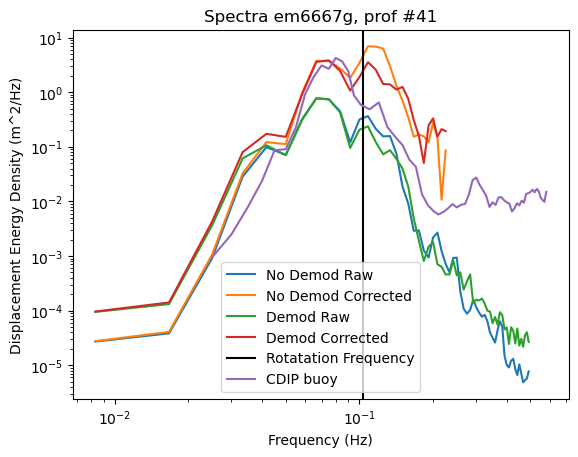

In [9]:
rot_f = 1/np.nanmean(VEL['RotP'][0])


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy

prof_speed = np.abs(z_y[:, 0]-z_y[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

[Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_y, prof_speed, nblock, 10, fs)



spec_no_demod = Eh
spec_no_demod_corr = Eh_Eric4


plt.loglog(fwindow[1:], np.nanmean(spec_no_demod, axis=0), label='No Demod Raw')
#plt.plot(fwindow[1:], np.transpose(spec_no_demod), color='k', alpha=0.2)
plt.loglog(fwindow[1:], np.nanmean(spec_no_demod_corr, axis=0), label='No Demod Corrected')
#plt.plot(fwindow[1:], np.transpose(spec_no_demod_corr), color='k', alpha=0.2)

plt.loglog(fwindow[1:], np.nanmean(spec_demod, axis=0), label='Demod Raw')
plt.loglog(fwindow[1:], np.nanmean(spec_demod_corr, axis=0), label='Demod Corrected')

plt.axvline(x = rot_f, color = 'k', label = 'Rotatation Frequency')

fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]

##Get Errors
#first need to match up teh 

ind2 = np.where(np.nanmean(mlt_efr)-times==np.min(np.abs(np.nanmean(mlt_efr))-times))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
cdip_ind = ind2[0]
plt.plot(wave_freq, energy_density[ind2[0][0], :], label="CDIP buoy")
plt.legend()


plt.xlabel("Frequency (Hz)")
plt.ylabel("Displacement Energy Density (m^2/Hz)")
plt.title("Spectra em6667g, prof #" + str(prof_num))

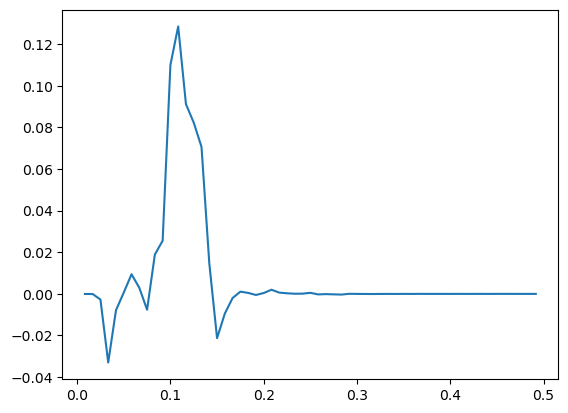

In [39]:
spec_diff = spec_no_demod - spec_demod
plt.plot(fwindow[1:],np.nanmean(spec_diff, axis=0))


In [40]:
efr_files

['ema-6667i-0041-efr.mat']

In [15]:
efr_files

['ema-6667g-0062-efr.mat']

In [48]:
plt.figure()
test_fit = np.zeros(np.shape(e1_reshape))
test_fit[:] = np.nan
for i in range(len(e1)):
    p1 = np.polyfit(x_new[i, :], e1_reshape[i, :], 2)
    pfit1 = np.poly1d(p1)
    plt.plot(x_new[i, :], pfit1(x_new[i, :]))
    plt.plot(x_new[i, :], e1_reshape[i, :])
    test_fit[i, :] = pfit1(x_new[i, :])

NameError: name 'e1_reshape' is not defined

<Figure size 640x480 with 0 Axes>

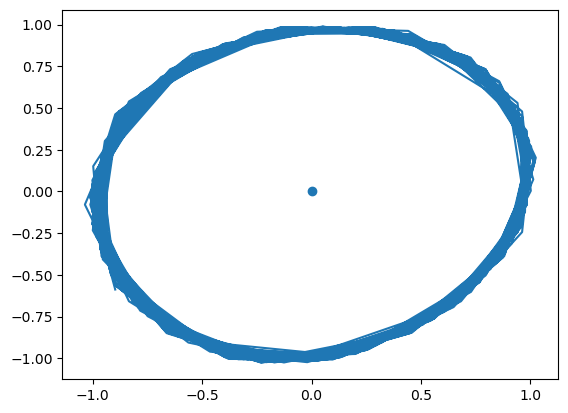

In [53]:
plt.plot(hx, hy)
plt.scatter(np.nanmean(hx), np.nanmean(hy))

In [153]:
import numpy as np
import matplotlib.pyplot as plt



def correct_magnetometer(hx, hy):
    """
    Function to remove hard and soft iron offsets from magnetometer data
    
    Input: 
        hx - x-magnetometer output
        hy - y-magnetometer output
    
    Output:
        hx_fixed
        hy_fixed
        
    References for corrections, and Ellipse equations 
        https://www.fierceelectronics.com/components/compensating-for-tilt-hard-iron-and-soft-iron-effects
        https://en.wikipedia.org/wiki/Ellipse
    """
    
    
    # Extract x coords and y coords of the ellipse as column vectors
    X = np.expand_dims(np.transpose(hx), axis=1)
    Y = np.expand_dims(np.transpose(hy), axis=1)
    F = np.ones_like(X)
    # Formulate and solve the least squares problem ||Ax - b ||^2
    A = np.hstack([X**2, X * Y, Y**2, X, Y])
    b = np.ones_like(X)
    x = np.linalg.lstsq(A, b)[0].squeeze()


    plt.scatter(X, Y, label='Raw Magnetometer')

    # Plot the least squares ellipse
    x_coord = np.linspace(-1.5,1.5,300)
    y_coord = np.linspace(-1.5,1.5,300)
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
    plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('k'), linewidths=2)
    plt.xlabel('X')
    plt.ylabel('Y')
    
    
    A=x[0]
    B=x[1]
    C=x[2]
    D=x[3]
    E=x[4]
    F=-1

    #eqn for theta
    theta = np.arctan((1/x[1])*(x[2]-x[0]-np.sqrt((x[0]-x[2])**2+x[1]**2)))

    #eqn for major and minor axes of ellipse
    a = - np.sqrt(2*(A*(E**2)+C*(D**2)-B*D*E+((B**2)-4*A*C)*F)*((A+C)+np.sqrt(((A-C)**2)+(B**2))))/((B**2)-4*A*C)
    b = - np.sqrt(2*(A*(E**2)+C*(D**2)-B*D*E+((B**2)-4*A*C)*F)*((A+C)-np.sqrt(((A-C)**2)+(B**2))))/((B**2)-4*A*C)

    #eqn for hard iron offset
    x0 = (2*C*D - B*E)/(B**2 - 4*A*C)
    y0 = (2*A*E - B*D)/(B**2 - 4*A*C)
    
    
    ellipse_coords = np.transpose(np.hstack([X, Y]))
    
    
    #Apply hard iron correction
    ellipse_coords[0, :] = ellipse_coords[0, :]-x0
    ellipse_coords[1, :] = ellipse_coords[1, :]-x0

    
    #Apply rotation matrix
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    ellipse_out=np.matmul(R, ellipse_coords)

    #Rescale elipse
    ellipse_out[0, :] = ellipse_out[0, :]/a
    ellipse_out[1, :] = ellipse_out[1, :]/b

    
    #Rotate back to correct orientation
    R2 = R = np.array([[np.cos(-theta), np.sin(-theta)], [-np.sin(-theta), np.cos(-theta)]])
    ellipse_out2=np.matmul(R2, ellipse_out)

    hx_fixed = ellipse_out2[0, :]
    hy_fixed = ellipse_out2[1, :]
    #Plot corrected data
    plt.scatter(hx_fixed, hy_fixed, label="Corrected Magnetometer", color='orange')


    #Fit to corrected ellipse
    # Extract x coords and y coords of the ellipse as column vectors
    
    X_fix = np.expand_dims(np.transpose(hx_fixed), axis=1)
    Y_fix = np.expand_dims(np.transpose(hy_fixed), axis=1)
    # Formulate and solve the least squares problem ||Ax - b ||^2
    A = np.hstack([X_fix**2, X_fix * Y_fix, Y_fix**2, X_fix, Y_fix])
    b = np.ones_like(X_fix)
    x = np.linalg.lstsq(A, b)[0].squeeze()

    # Plot the least squares corrected ellipse
    x_coord = np.linspace(-1.5,1.5,300)
    y_coord = np.linspace(-1.5,1.5,300)
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
    plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('k'), linewidths=2, linestyles='dashed')
    plt.legend()


    return(hx_fixed, hy_fixed)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/2541105562.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/2541105562.py:41: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('k'), linewidths=2, label="Raw Fit")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_54185/2541105562.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explici

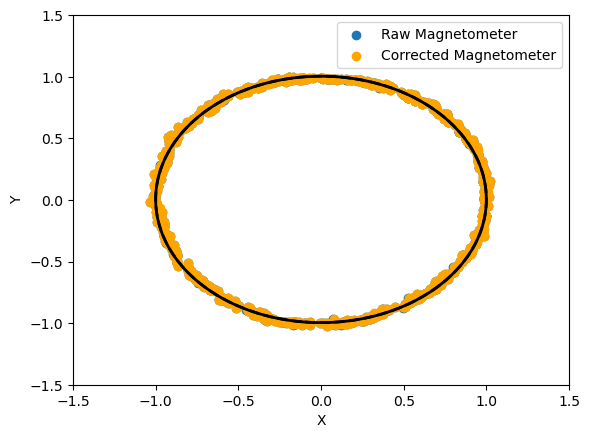

In [152]:
hx, hy = correct_magnetometer(hx, hy)

In [127]:
b

0.9457023057219168

In [82]:
R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [83]:
R.shape

(2, 2)

In [93]:
test = np.transpose(np.hstack([X, Y]))

In [94]:
test.shape

(2, 767)

In [96]:
test_out=np.matmul(R, test)

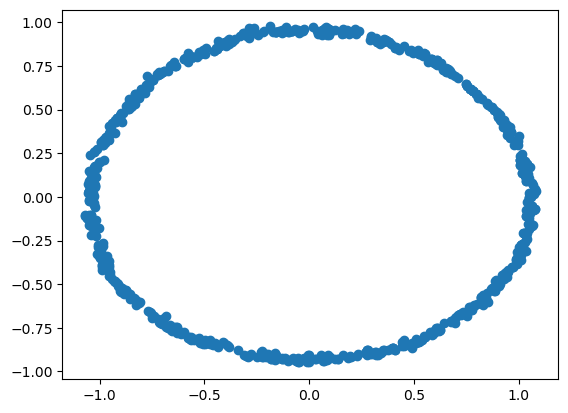

In [98]:
plt.scatter(test_out[0, :], test_out[1, :])

In [102]:
ymin = np.min(test[1, :])
ymax = np.max(test[1, :])
print(ymin, ymax)

-1.025303240738734 0.9891900162218236


In [136]:
ellipse_out2[0, :].shape

(767,)

In [104]:
np.nanmean(test[0, :])

-4.875138392356619e-16

In [121]:
x.shape

(5,)

(-200.0, 200.0)

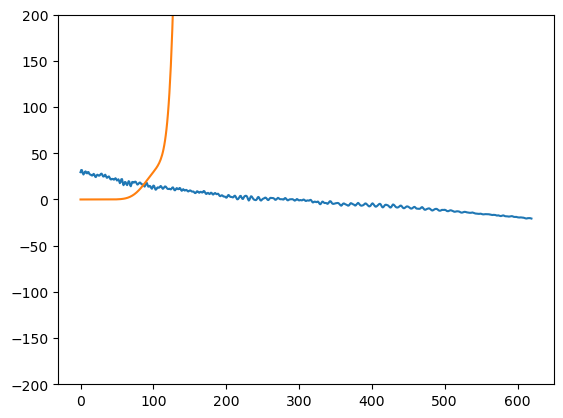

In [209]:

from scipy.signal import butter, lfilter, freqz

b, a = butter(16, 0.01/0.5, fs=1, btype='low', analog=False)
y = lfilter(b, a, e1-np.nanmean(e1))

plt.plot(e1-np.nanmean(e1))
plt.plot(y)
plt.ylim(-200, 200)

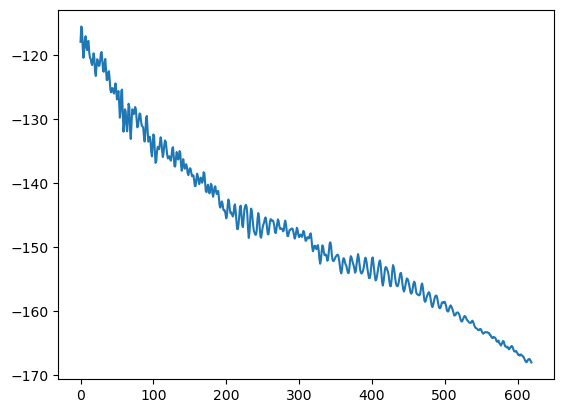

In [186]:
plt.plot(e1)